In [1]:
import dask.dataframe as dd
import dask.distributed
import numpy as np
import pandas as pd

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib
import matplotlib.pyplot as plt

import seaborn.apionly as sns
from matplotlib.colors import SymLogNorm as symlog

from skimage import exposure
from matplotlib.ticker import MultipleLocator, FormatStrFormatter, AutoMinorLocator

import rs_style
rs_style.style_matplotlib()

In [2]:
import datashader as ds
import datashader.transfer_functions as tf

import datashader as ds
from datashader.bokeh_ext import InteractiveImage
from functools import partial
from datashader.utils import export_image
from datashader.colors import colormap_select, viridis, inferno
from IPython.core.display import HTML, display

from bokeh.models import BoxZoomTool
from bokeh.plotting import figure, output_notebook, show

output_notebook()

Loading BokehJS ...

### Setup Dask Cluster

In [3]:
client = dask.distributed.Client()

In [4]:
client.restart()

<Client: scheduler='tcp://127.0.0.1:35519' processes=4 cores=4>

### Load Data and Inspect

In [5]:
# Load only the columns we need, large speedup.

df = dd.read_parquet('/data/NYC_taxi_2009-2016.parquet', engine='arrow', 
                     columns=
                     [
                        'pickup_datetime', 
                        'pickup_longitude', 
                        'pickup_latitude', 
                        'pickup_taxizone_id',
                        'dropoff_datetime', 
                        'dropoff_longitude', 
                        'dropoff_latitude', 
                        'dropoff_taxizone_id',
                        'trip_type'
                    ])
df = df[df.trip_type != '"uber"']

In [6]:
df.head()

pickup_datetime  pickup_longitude  pickup_latitude  pickup_taxizone_id  \
0 2009-01-01 00:00:00        -73.965919        40.771244               237.0   
1 2009-01-01 00:00:00        -73.997482        40.725952               114.0   
2 2009-01-01 00:00:02        -73.964798        40.767391               237.0   
3 2009-01-01 00:00:04        -74.011597        40.708832               261.0   
4 2009-01-01 00:00:07        -74.000648        40.718578               144.0   

     dropoff_datetime  dropoff_longitude  dropoff_latitude  \
0 2009-01-01 00:04:12         -73.949608         40.777058   
1 2009-01-01 00:05:03         -74.005936         40.735703   
2 2009-01-01 00:05:40         -73.977753         40.773746   
3 2009-01-01 00:03:08         -74.013466         40.709358   
4 2009-01-01 00:19:01         -73.944580         40.712368   

   dropoff_taxizone_id trip_type  
0                263.0  "yellow"  
1                249.0  "yellow"  
2                 43.0  "yellow"  
3                261.0  "yellow"  
4                 80.0  "yellow"

### Select Data within bounds, Convert to Web Mercator Coordinates

In [7]:
#Select only those points within some reasonable bounds (half a degree)

df = df[df.pickup_latitude.notnull() & df.pickup_longitude.notnull() 
        & ((df.pickup_latitude - 40.75).abs() <= 0.5) 
        & ((df.pickup_longitude + 73.9).abs() <= 0.5)
       ]
df = df[df.dropoff_latitude.notnull() & df.dropoff_longitude.notnull() 
        & ((df.dropoff_latitude - 40.75).abs() <= 0.5) 
        & ((df.dropoff_longitude + 73.9).abs() <= 0.5)
       ]

In [8]:
def convert_lon(d, latvar):
    "Convert longitude to web mercator"
    k = d[latvar].copy()
    k = (20037508.34 / 180) * (np.log(np.tan((90. + d[latvar]) * np.pi/360))/(np.pi/180.))
    return k

# Convert lats and lons to web mercator projection
df['pickup_longitude'] = df.pickup_longitude * (20037508.34 / 180)
df['pickup_latitude'] = df.map_partitions(convert_lon, 'pickup_latitude')
df['dropoff_longitude'] = df.dropoff_longitude * (20037508.34 / 180)
df['dropoff_latitude'] = df.map_partitions(convert_lon, 'dropoff_latitude')

# Consolidate partitions for faster plotting
df.to_parquet('/tmp/filtered.parquet', compression='SNAPPY')

In [5]:
df = dd.read_parquet('/tmp/filtered.parquet')

In [6]:
# We get about 1.27 billion points
df.pickup_latitude.count().compute()

1268170371

In [24]:
# Read the consolidated data back in
df2 = dd.read_parquet('/tmp/filtered.parquet', columns=['dropoff_longitude', 
                                                        'dropoff_latitude', 'pickup_latitude'])

# Subsample the data and persist (optional, but speeds up plotting)
df2 = df2.sample(0.05).repartition(npartitions=200)
df2.to_parquet('/tmp/filtered_dropoffs.parquet', compression='SNAPPY')
df2 = dd.read_parquet('/tmp/filtered_dropoffs.parquet')

# Plot Dropoffs using Datashader

In [25]:
#set centers, bounds, and ranges in web mercator coords
x_center = -8234000 
y_center = 4973000

x_half_range = 30000
y_half_range = 25000

NYC = x_range, y_range = ((x_center - x_half_range, x_center + x_half_range), 
                          (y_center-y_half_range, y_center+y_half_range))

# plot_width scales (quadratically?) with memory consumption.
# With 32GB RAM, I can set this to 2000, but 2500 crashes with MemoryError.
# I used this setting for high quality, large plots. 
# plot_width = 2000 

# plot_width of 400 seems to require less than 4GB, and makes the notebook more manageable. 
# Also changes aesthetic appearance by decreasing GPS "noise" due to coarse binning
plot_width  = 1000 

# auto calculate from width
plot_height = int(plot_width/(x_half_range/y_half_range))

def base_plot(tools='pan,wheel_zoom,reset,save',plot_width=plot_width, 
              plot_height=plot_height, **plot_args):
    p = figure(tools=tools, plot_width=plot_width, plot_height=plot_height,
        x_range=x_range, y_range=y_range, outline_line_color=None,
        min_border=0, min_border_left=0, min_border_right=0,
        min_border_top=0, min_border_bottom=0, **plot_args)
    
    p.axis.visible = False
    p.xgrid.grid_line_color = None
    p.ygrid.grid_line_color = None
    
    p.add_tools(BoxZoomTool(match_aspect=True))
    
    return p
    
options = dict(line_color=None, fill_color='blue', size=5)

In [26]:
background = "black"
export = partial(export_image, export_path="export", background=background)
cm = partial(colormap_select, reverse=(background=="black"))

def create_image_2(x_range, y_range, w=plot_width, h=plot_height):
    cvs = ds.Canvas(plot_width=w, plot_height=h, x_range=x_range, y_range=y_range)
    agg = cvs.points(df2, 'dropoff_longitude', 'dropoff_latitude', ds.count('pickup_latitude'))
    img = tf.shade(agg, cmap=inferno, how='eq_hist')
    return tf.dynspread(img, threshold=0.5, max_px=4)

In [27]:
p = base_plot(background_fill_color=background)
export(create_image_2(x_range, y_range, plot_width, plot_height),"dropoffs_large_wide")
InteractiveImage(p, create_image_2)

### Calculate GPS Error and Plot

In [11]:
df3 = df[df.pickup_datetime < '2016-07-01']
def recast_to_monthly(d):
    return d.pickup_datetime.values.astype('<M8[M]').astype('<M8[ns]')
df3['pickup_datetime'] = df3.map_partitions(recast_to_monthly, meta=((None, 'M8[ns]')))

In [12]:
df_grouped = df3.groupby('pickup_datetime').count().compute()

In [13]:
df_grouped['pickup_valid_fraction'] = df_grouped['pickup_taxizone_id'].astype(np.float64) / df_grouped['pickup_longitude'].astype(np.float64)
df_grouped['dropoff_valid_fraction'] = df_grouped['dropoff_taxizone_id'].astype(np.float64) / df_grouped['dropoff_longitude'].astype(np.float64)

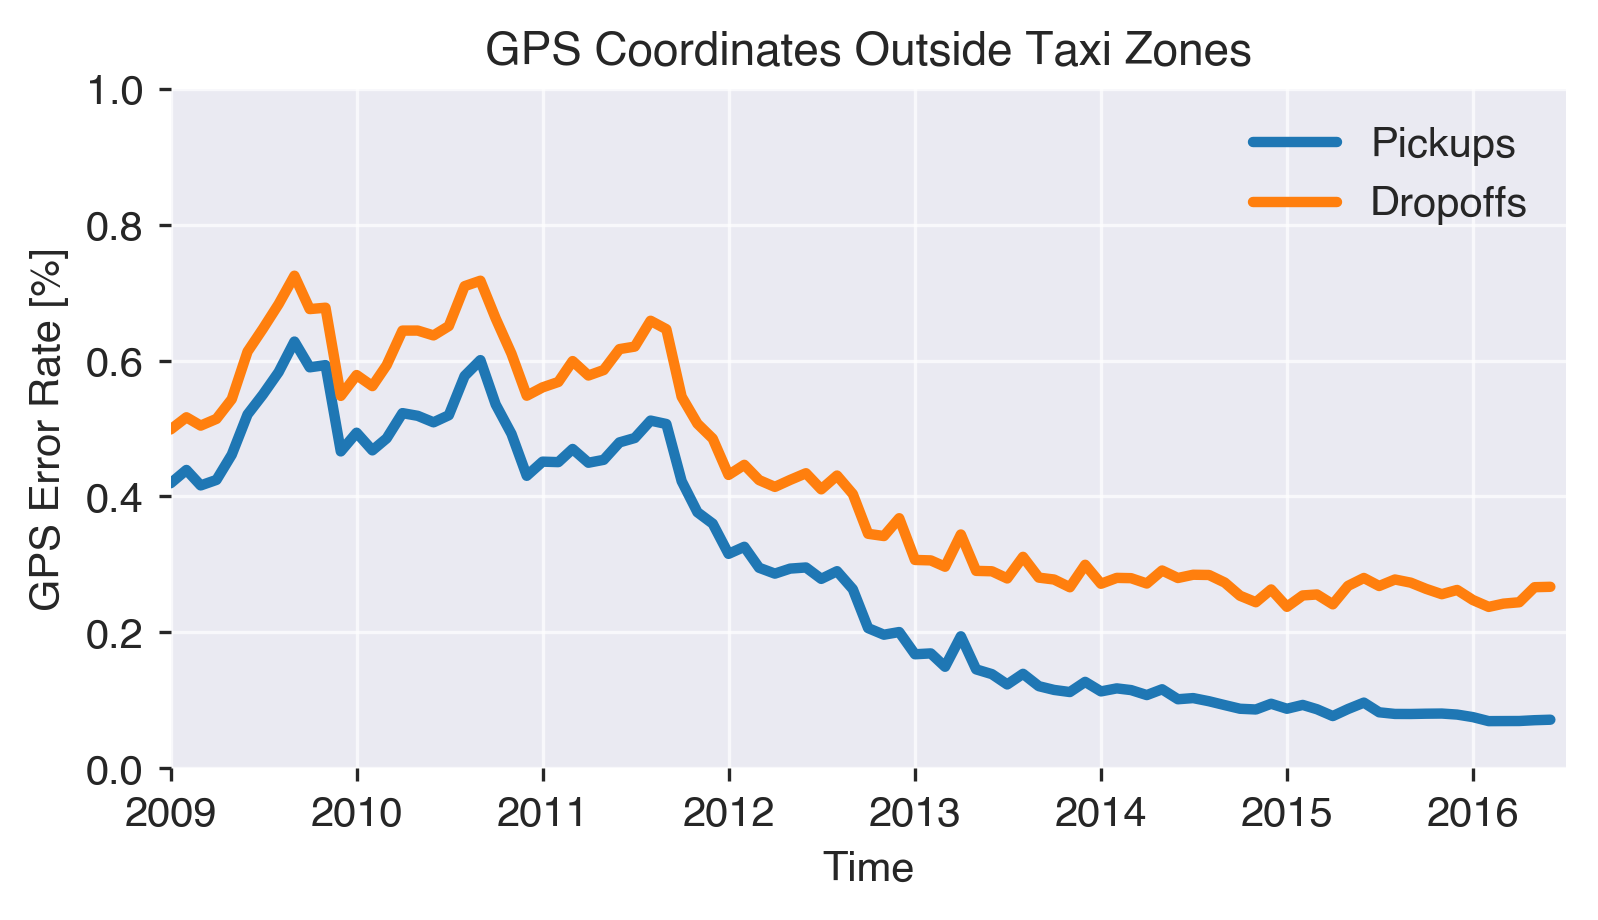

In [14]:
plt.plot(df_grouped.index.values, 100*(1.0 - df_grouped.pickup_valid_fraction.values), 
          label='Pickups', lw=2.5)
plt.plot(df_grouped.index.values, 100*(1.0 - df_grouped.dropoff_valid_fraction.values), 
          label='Dropoffs', lw=2.5)
plt.legend(loc='upper right')
plt.xlabel("Time")
plt.ylabel("GPS Error Rate [%]")
plt.title("GPS Coordinates Outside Taxi Zones")
plt.ylim(0, 1)
plt.xlim('2009-01', '2016-07')
plt.gcf().set_size_inches(6, 3)

# Temporal Heatmap

In [18]:
pickups = df[['pickup_datetime', 'pickup_taxizone_id']]

In [19]:
pickups.columns = ['t', 'id']

In [20]:
# Rounded to nearest 6 minutes (0.1 hour) for easier aggregation
pickups['timeofday'] = (pickups.t.dt.hour + (pickups.t.dt.minute // 6)/10)

In [21]:
pickups['dayofweek'] = pickups.t.dt.dayofweek
# pickups['weekofyear'] = pickups.t.dt.weekofyear
pickups['weeks_since_2009'] = (pickups.t - np.datetime64('2009-01-01 00:00:00').astype('<M8[ns]')).astype('timedelta64[W]').astype('i4')

In [22]:
def isbusday(d):
    return np.is_busday(d.t.values.astype('<M8[D]')).astype(int)

pickups['isbusday'] = pickups.map_partitions(isbusday, meta=(None, int))

In [23]:
# pickups = pickups[(pickups.isbusday == 1) | (pickups.dayofweek > 4)]

In [24]:
pickups.head()

t     id  timeofday  dayofweek  weeks_since_2009  isbusday
0 2009-01-01 00:00:00  237.0        0.0          3                 0         1
1 2009-01-01 00:00:00  114.0        0.0          3                 0         1
2 2009-01-01 00:00:02  237.0        0.0          3                 0         1
3 2009-01-01 00:00:04  261.0        0.0          3                 0         1
4 2009-01-01 00:00:07  144.0        0.0          3                 0         1

In [25]:
heatmap_all_pickups = pickups[['id', 'timeofday', 'dayofweek', 'weeks_since_2009']].groupby(
    ['weeks_since_2009', 'dayofweek', 'timeofday']).count().groupby(['dayofweek', 'timeofday']).mean().compute().reset_index()
heatmap_all_pickups_std = pickups[['id', 'timeofday', 'dayofweek', 'weeks_since_2009']].groupby(
    ['weeks_since_2009', 'dayofweek', 'timeofday']).count().compute().groupby(['dayofweek', 'timeofday']).std().reset_index()

In [26]:
heatmap_all_pickups.sort_values(['dayofweek', 'timeofday'], inplace=True)
heatmap_all_pickups_std.sort_values(['dayofweek', 'timeofday'], inplace=True)

In [27]:
dropoffs =  df[['dropoff_datetime', 'dropoff_taxizone_id']]

In [28]:
dropoffs.columns = ['t', 'id']

In [29]:
# Rounded to nearest 6 minutes (0.1 hour) for easier aggregation
dropoffs['timeofday'] = (dropoffs.t.dt.hour + (dropoffs.t.dt.minute // 6)/10)

In [30]:
dropoffs['dayofweek'] = dropoffs.t.dt.dayofweek
# pickups['weekofyear'] = pickups.t.dt.weekofyear
dropoffs['weeks_since_2009'] = (dropoffs.t - np.datetime64('2009-01-01 00:00:00').astype('<M8[ns]')).astype('timedelta64[W]').astype('i4')

In [31]:
dropoffs = dropoffs[dropoffs.weeks_since_2009 > 0]

In [32]:
def isbusday(d):
    return np.is_busday(d.t.values.astype('<M8[D]')).astype(int)

dropoffs['isbusday'] = dropoffs.map_partitions(isbusday, meta=(None, int))

In [33]:
# dropoffs = dropoffs[(dropoffs.isbusday == 1) | (dropoffs.dayofweek > 4)]

In [34]:
heatmap_all_dropoffs = dropoffs[['id', 'timeofday', 'dayofweek', 'weeks_since_2009']].groupby(['weeks_since_2009', 'dayofweek', 'timeofday']).count().groupby(['dayofweek', 'timeofday']).mean().compute().reset_index()
heatmap_all_dropoffs_std = dropoffs[['id', 'timeofday', 'dayofweek', 'weeks_since_2009']].groupby(['weeks_since_2009', 'dayofweek', 'timeofday']).count().compute().groupby(['dayofweek', 'timeofday']).std().reset_index()

In [35]:
heatmap_all_dropoffs.sort_values(['dayofweek', 'timeofday'], inplace=True)
heatmap_all_dropoffs_std.sort_values(['dayofweek', 'timeofday'], inplace=True)

In [36]:
pickup_counts = np.zeros((7, 240), dtype=np.float32) 
dropoff_counts = np.zeros((7, 240), dtype=np.float32) 

pickup_counts_std = np.zeros((7, 240), dtype=np.float32) 
dropoff_counts_std = np.zeros((7, 240), dtype=np.float32) 

for weekday in range(7):
    pickup_counts[weekday, :] = heatmap_all_pickups[heatmap_all_pickups.dayofweek == weekday].id.values * 10 # convert units into counts per hour
    dropoff_counts[weekday, :] = heatmap_all_dropoffs[heatmap_all_dropoffs.dayofweek == weekday].id.values * 10 # same
    
    pickup_counts_std[weekday, :] = heatmap_all_pickups_std[heatmap_all_pickups.dayofweek == weekday].id.values * 10 # convert units into counts per hour
    dropoff_counts_std[weekday, :] = heatmap_all_dropoffs_std[heatmap_all_dropoffs.dayofweek == weekday].id.values * 10 # same

In [37]:
pickup_counts = np.roll(pickup_counts.ravel(), -60).reshape(pickup_counts.shape)
dropoff_counts = np.roll(dropoff_counts.ravel(), -60).reshape(dropoff_counts.shape)
pickup_counts_std = np.roll(pickup_counts_std.ravel(), -60).reshape(pickup_counts_std.shape)
dropoff_counts_std = np.roll(dropoff_counts_std.ravel(), -60).reshape(dropoff_counts_std.shape)

In [38]:
pickups_rescaled = exposure.equalize_hist(pickup_counts)
pickups_rescaled_std = exposure.equalize_hist(pickup_counts_std)

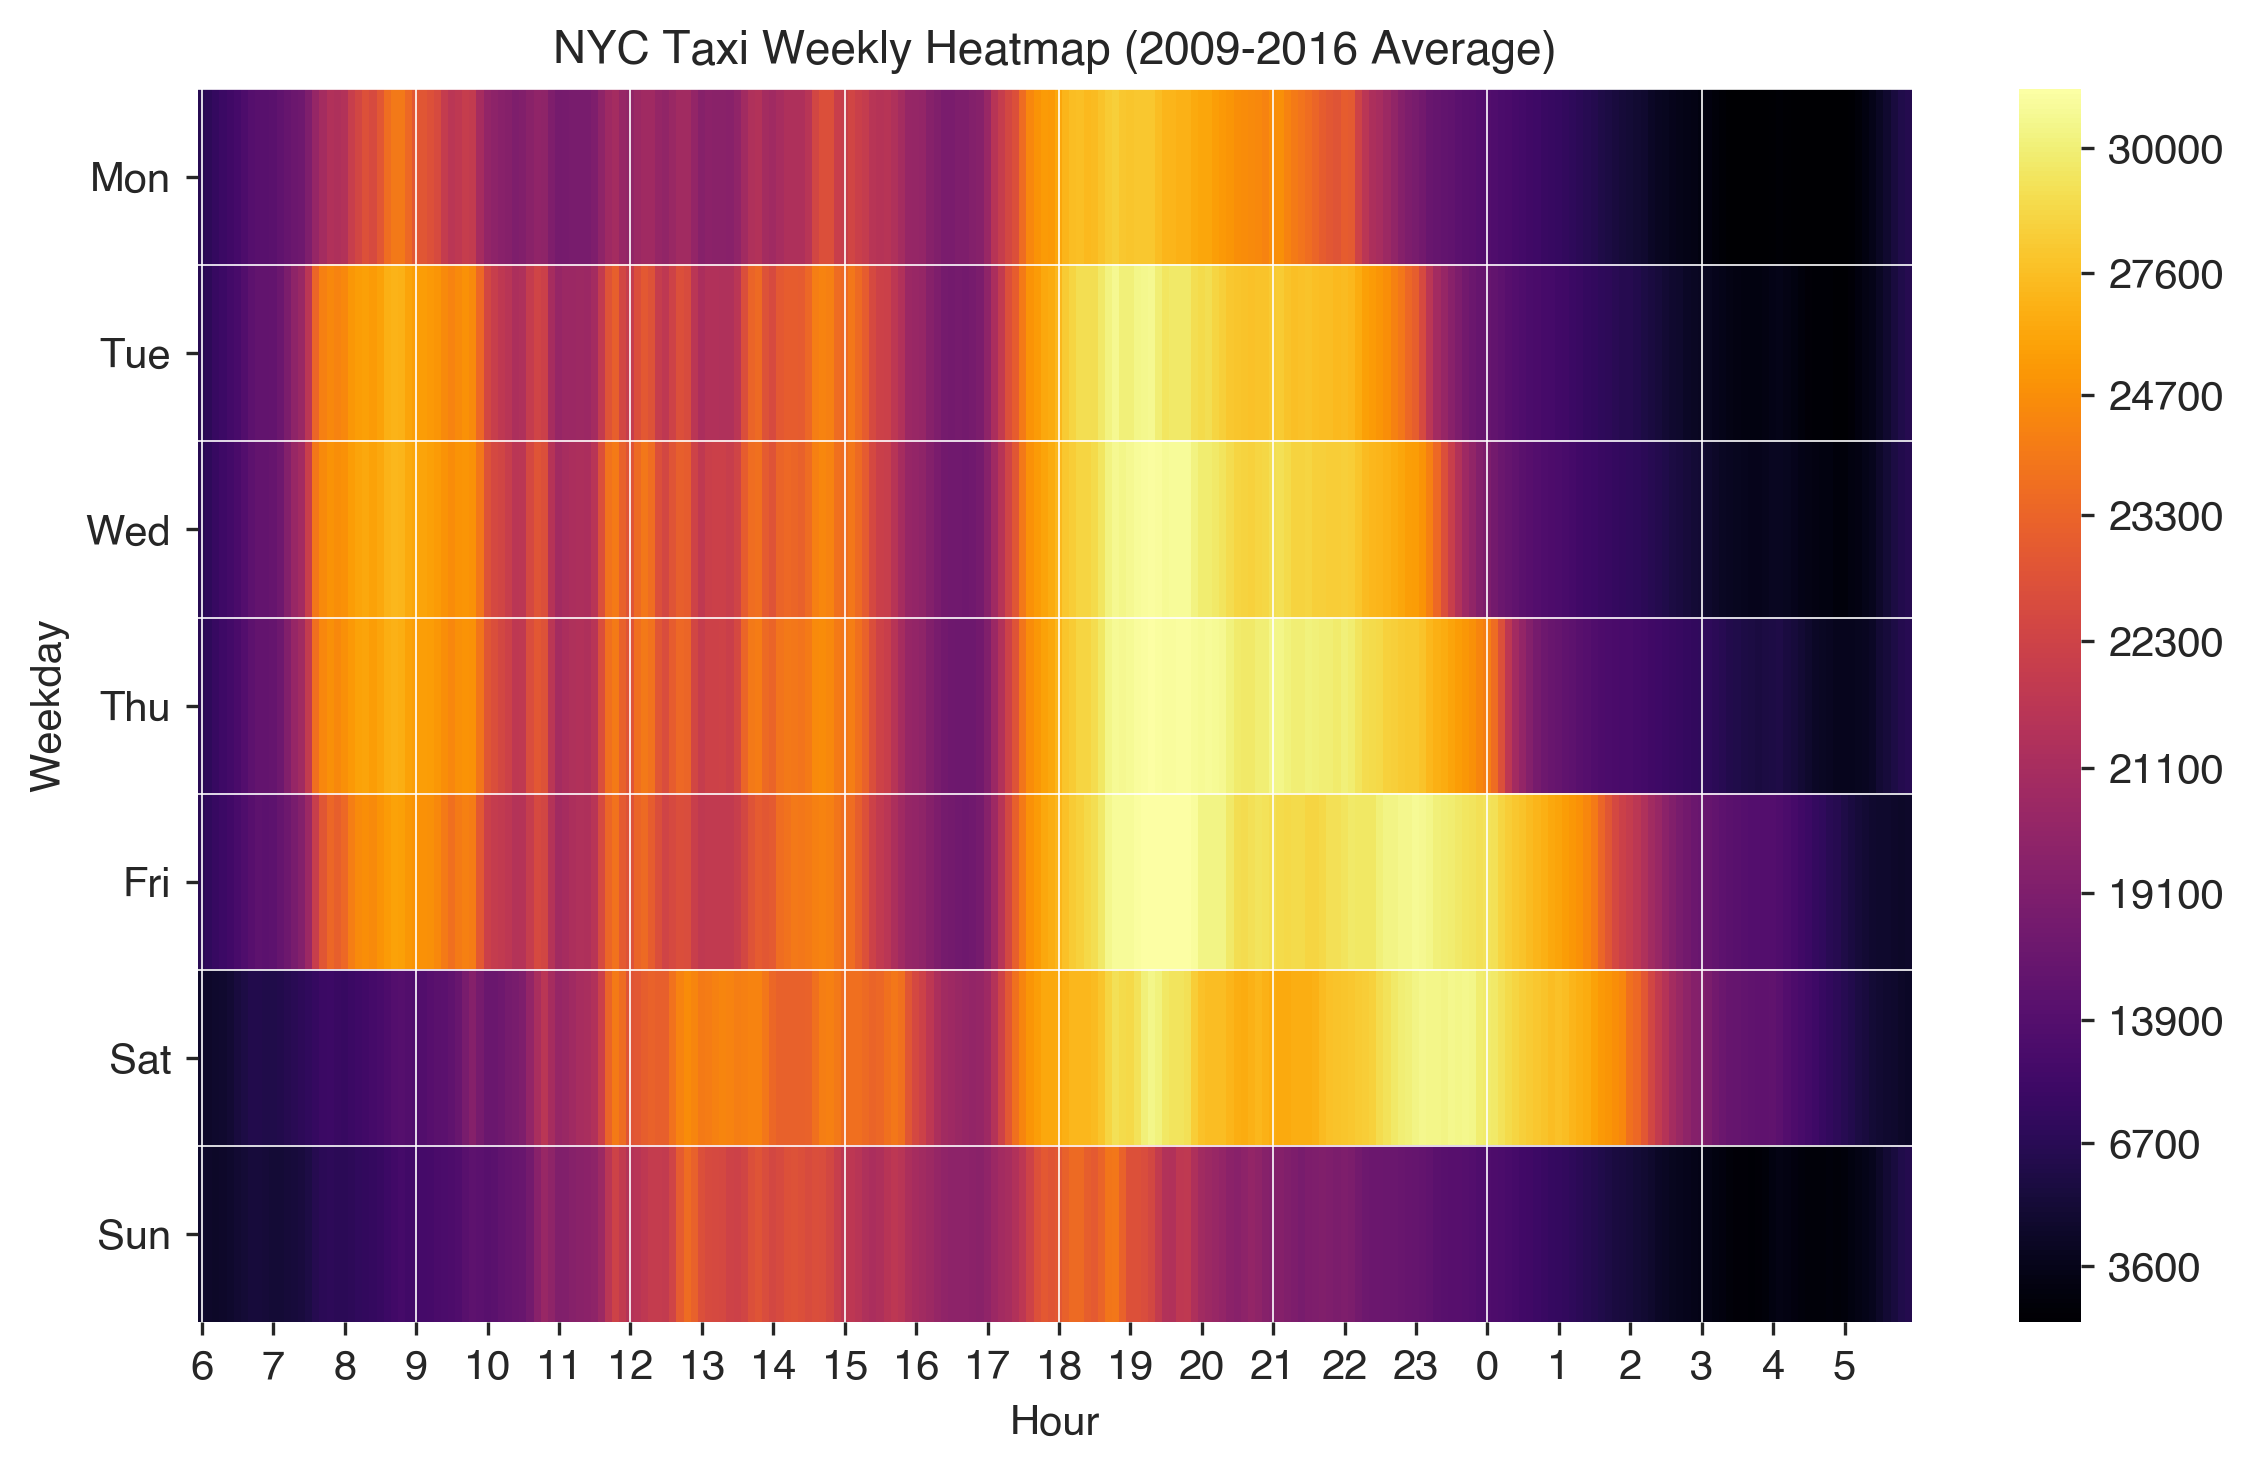

In [39]:
plt.imshow(pickups_rescaled, aspect='auto', interpolation='none', cmap=plt.cm.inferno)
plt.gcf().set_size_inches(8, 5)
cb = plt.colorbar(orientation='vertical')
cb.set_ticks(np.percentile(pickups_rescaled.ravel(), q=np.arange(5, 100, 10)))
cb.set_ticklabels((np.percentile(pickup_counts.ravel(), q=np.arange(5, 100, 10)).round(-2)).astype(int).astype(str))

plt.gca().yaxis.set_ticklabels(['', 'Mon', 'Tue',  "Wed", 'Thu', 'Fri',  'Sat', 'Sun'])

plt.xticks(np.arange(0, 240, 10))
plt.gca().xaxis.set_ticklabels(np.roll([str(x) for x in range(0, 24)], -6))
plt.xlabel("Hour")
plt.ylabel("Weekday")
plt.grid(False, which='both')

for i in range(7):
    plt.axhline(i-0.5, color='w', lw=0.4)
for i in range(0, 240, 30):
    plt.axvline(i, color='w', lw=0.4)
    
    
plt.title("NYC Taxi Weekly Heatmap (2009-2016 Average)")
plt.tight_layout()

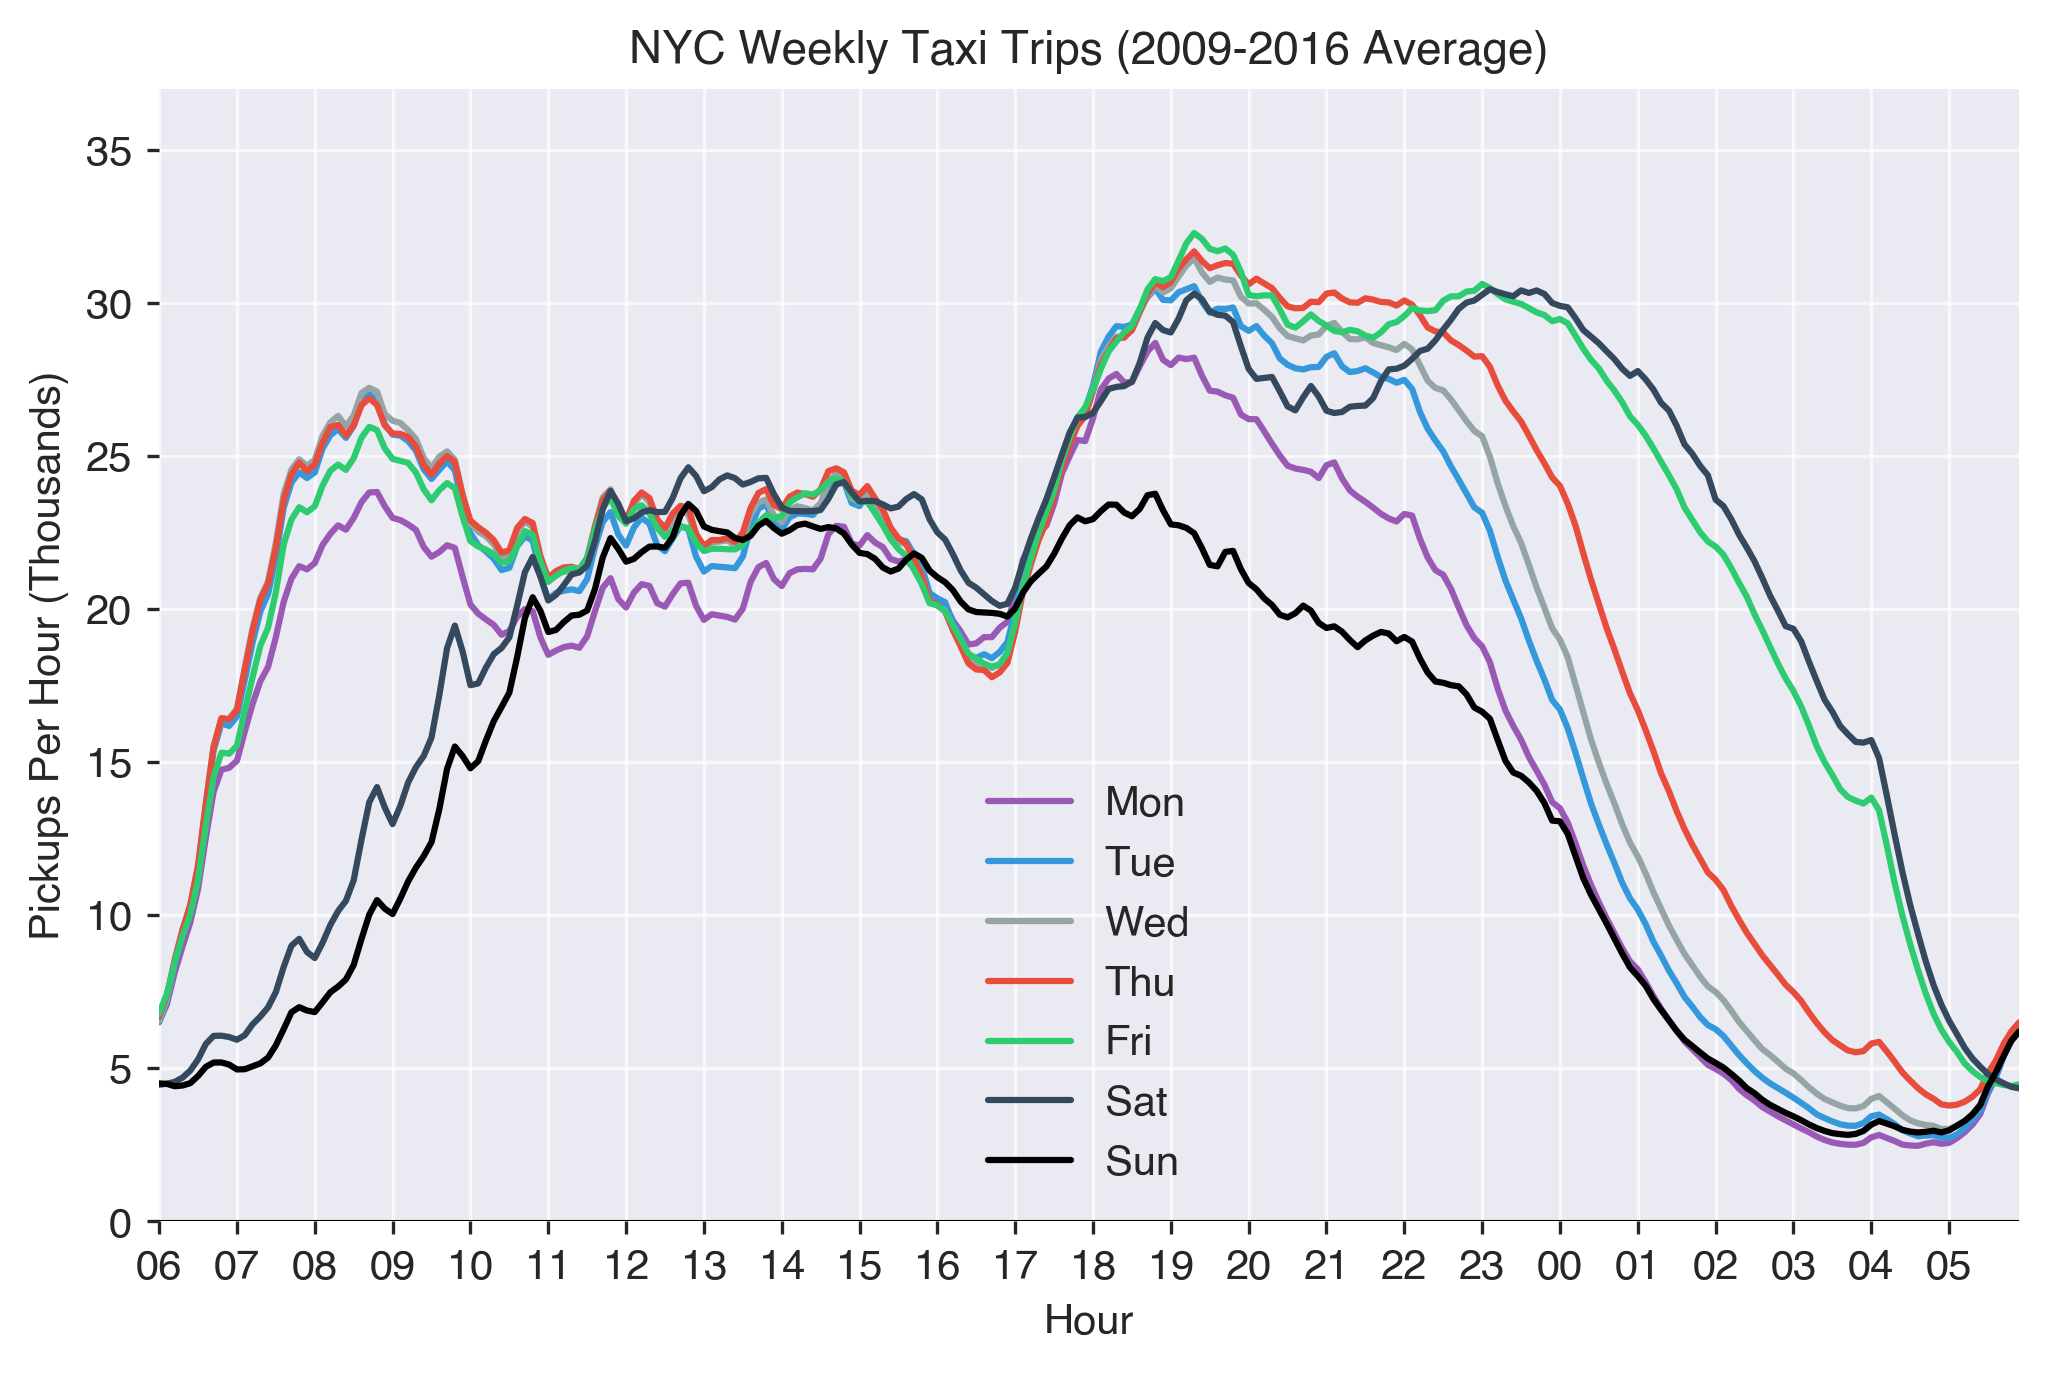

In [40]:
xv = pd.date_range('2009-01-01 06:00:00', '2009-01-02 05:54:00', freq='6T').values

palette = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#2ecc71", "#34495e", "#000000"]

for i,day in enumerate(['Mon', 'Tue',  "Wed", 'Thu', 'Fri',  'Sat', 'Sun']):
    plt.plot(xv, 0.001*(pickup_counts)[i], label=day, color=palette[i])

plt.gcf().set_size_inches(8, 5)
plt.xlim('2009-01-01 06:00:00', '2009-01-02 05:54:00')
plt.legend(loc='lower center')
plt.gca().xaxis.set_ticks(pd.date_range('2009-01-01 06:00:00', '2009-01-02 05:54:00', freq='H').values)
plt.gca().xaxis.set_ticklabels(pd.date_range('2009-01-01 06:00:00', '2009-01-02 05:54:00', freq='H').strftime('%H'))
plt.ylim(0, 37)
plt.axhline(0, color='k', lw=0.5)

plt.xlabel("Hour")
plt.ylabel("Pickups Per Hour (Thousands)")
plt.title("NYC Weekly Taxi Trips (2009-2016 Average)")

# plt.savefig('04_temporal_figures/weekly_pickups_lines.png', dpi=300)

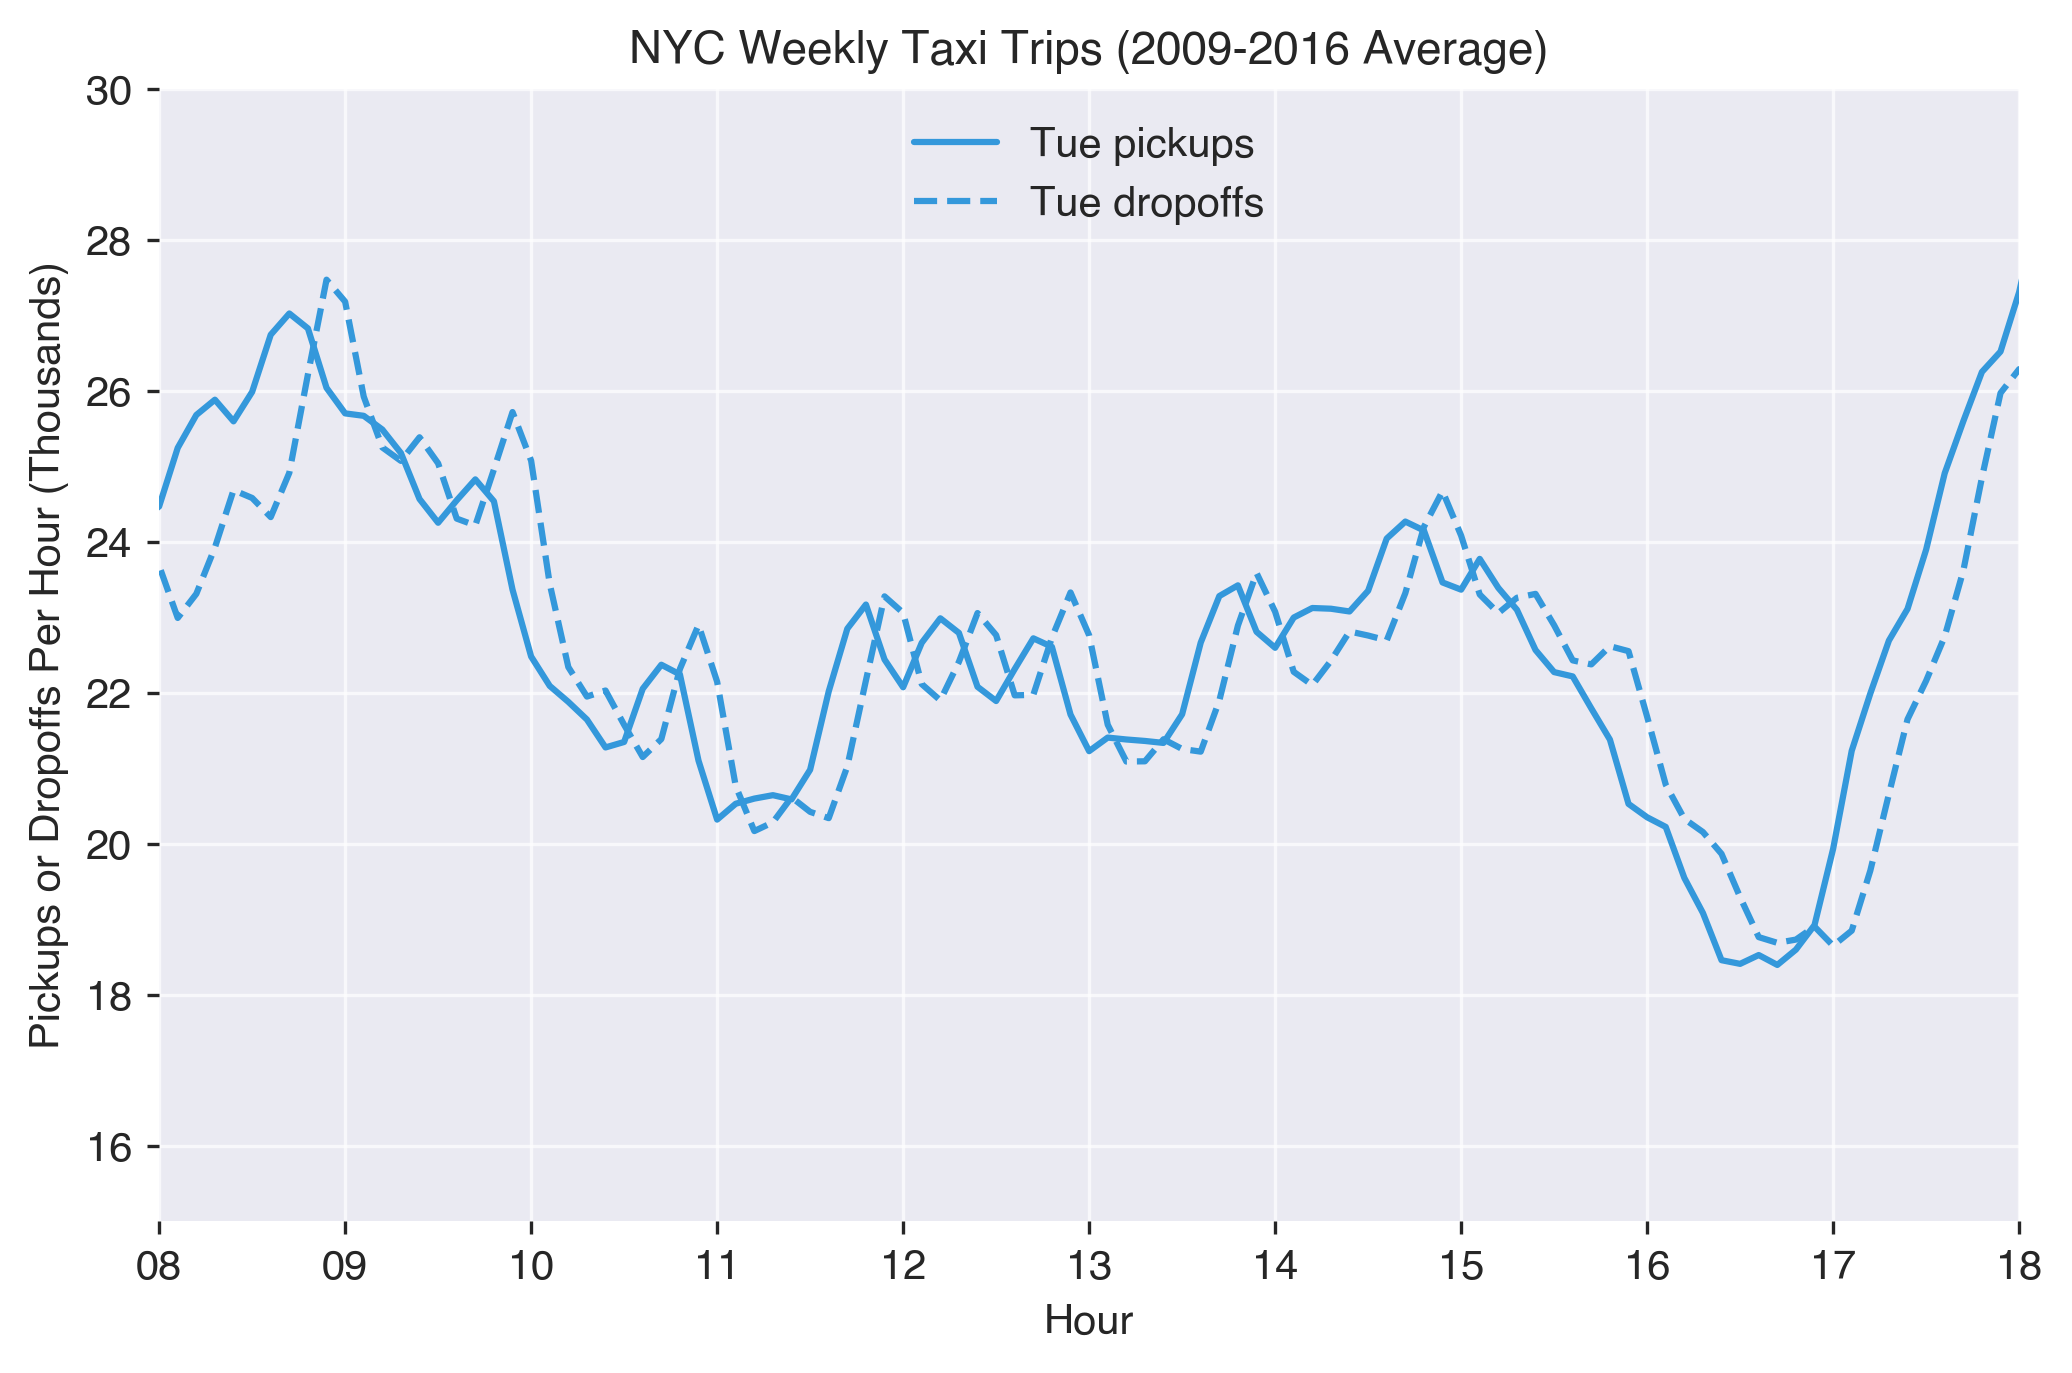

In [41]:
xv = pd.date_range('2009-01-01 06:00:00', '2009-01-02 05:54:00', freq='6T').values

palette = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#2ecc71", "#34495e", "#000000"]

for i,day in enumerate(['Mon', 'Tue',  "Wed", 'Thu', 'Fri',  'Sat', 'Sun']):
    if i== 1:
        plt.plot(xv, 0.001*(pickup_counts)[i], label=day + " pickups", color=palette[i])
        plt.plot(xv, 0.001*(dropoff_counts)[i], label=day + " dropoffs", color=palette[i], linestyle='--')

plt.gcf().set_size_inches(8, 5)
plt.xlim('2009-01-01 08:00:00', '2009-01-01 18:00:00')
plt.legend(loc='upper center')
plt.gca().xaxis.set_ticks(pd.date_range('2009-01-01 08:00:00', '2009-01-01 18:00:00', freq='H').values)
plt.gca().xaxis.set_ticklabels(pd.date_range('2009-01-01 08:00:00', '2009-01-01 18:00:00', freq='H').strftime('%H'))
plt.ylim(15, 30)
plt.axhline(0, color='k', lw=0.5)

plt.xlabel("Hour")
plt.ylabel("Pickups or Dropoffs Per Hour (Thousands)")
plt.title("NYC Weekly Taxi Trips (2009-2016 Average)")

# plt.savefig('04_temporal_figures/weekly_pickups_lines_tuesday.png', dpi=300)

# Trends

In [42]:
heatmap_all_pickups_all = (pickups[['id', 'timeofday', 'dayofweek', 'weeks_since_2009']] \
                            .groupby(['dayofweek', 'timeofday', 'weeks_since_2009']).count().compute())

In [43]:
import statsmodels.api as sm

/home/shekhar/anaconda3/envs/py35/lib/python3.5/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [44]:
grouped = heatmap_all_pickups_all.reset_index().groupby(['dayofweek', 'timeofday'])

rows = []

for group in grouped.groups.keys():
    df_g = grouped.get_group(group)
    df_g['constant']=1
    X = df_g[['weeks_since_2009','constant']]
    y = df_g['id']
    model = sm.OLS(y,X)
    results = model.fit()
    
    rows.append(group + (results.params.weeks_since_2009, results.params.constant, 
                         results.rsquared_adj, results.pvalues.weeks_since_2009))


/home/shekhar/anaconda3/envs/py35/lib/python3.5/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


In [45]:
df_pickup_trend_slopes = pd.DataFrame.from_records(
    rows, columns=['dayofweek', 'timeofday', 'slope', 'intercept', 'rsq_adj', 'pvalue']
                                                  ).sort_values(['dayofweek', 'timeofday'])

In [46]:
pickup_trends = np.zeros((7, 240), dtype=np.float32) 
pickup_trends_rsq_adj = np.zeros((7, 240), dtype=np.float32)
pickup_trends_pvalue = np.zeros((7, 240), dtype=np.float32)

for weekday in range(7):
    pickup_trends[weekday, :] = df_pickup_trend_slopes[df_pickup_trend_slopes.dayofweek == weekday].slope.values * 10 * 52 # convert units into counts per hour
    pickup_trends_rsq_adj[weekday, :] = df_pickup_trend_slopes[df_pickup_trend_slopes.dayofweek == weekday].rsq_adj.values
    pickup_trends_pvalue[weekday, :] = df_pickup_trend_slopes[df_pickup_trend_slopes.dayofweek == weekday].pvalue.values
    
pickup_trends = np.roll(pickup_trends.ravel(), -60).reshape(pickup_trends.shape)
pickup_trends_rsq_adj = np.roll(pickup_trends_rsq_adj.ravel(), -60).reshape(pickup_trends_rsq_adj.shape)
pickup_trends_pvalue = np.roll(pickup_trends_pvalue.ravel(), -60).reshape(pickup_trends_pvalue.shape)

In [47]:
import scipy.ndimage

pickup_trends_smoothed = scipy.ndimage.filters.gaussian_filter1d(
    pickup_trends.ravel(), sigma=2, axis=-1, mode='wrap').reshape(pickup_trends.shape)
pickup_counts_smoothed = scipy.ndimage.filters.gaussian_filter1d(
    pickup_counts.ravel(), sigma=2, axis=-1, mode='wrap').reshape(pickup_counts.shape)

(0, 240)

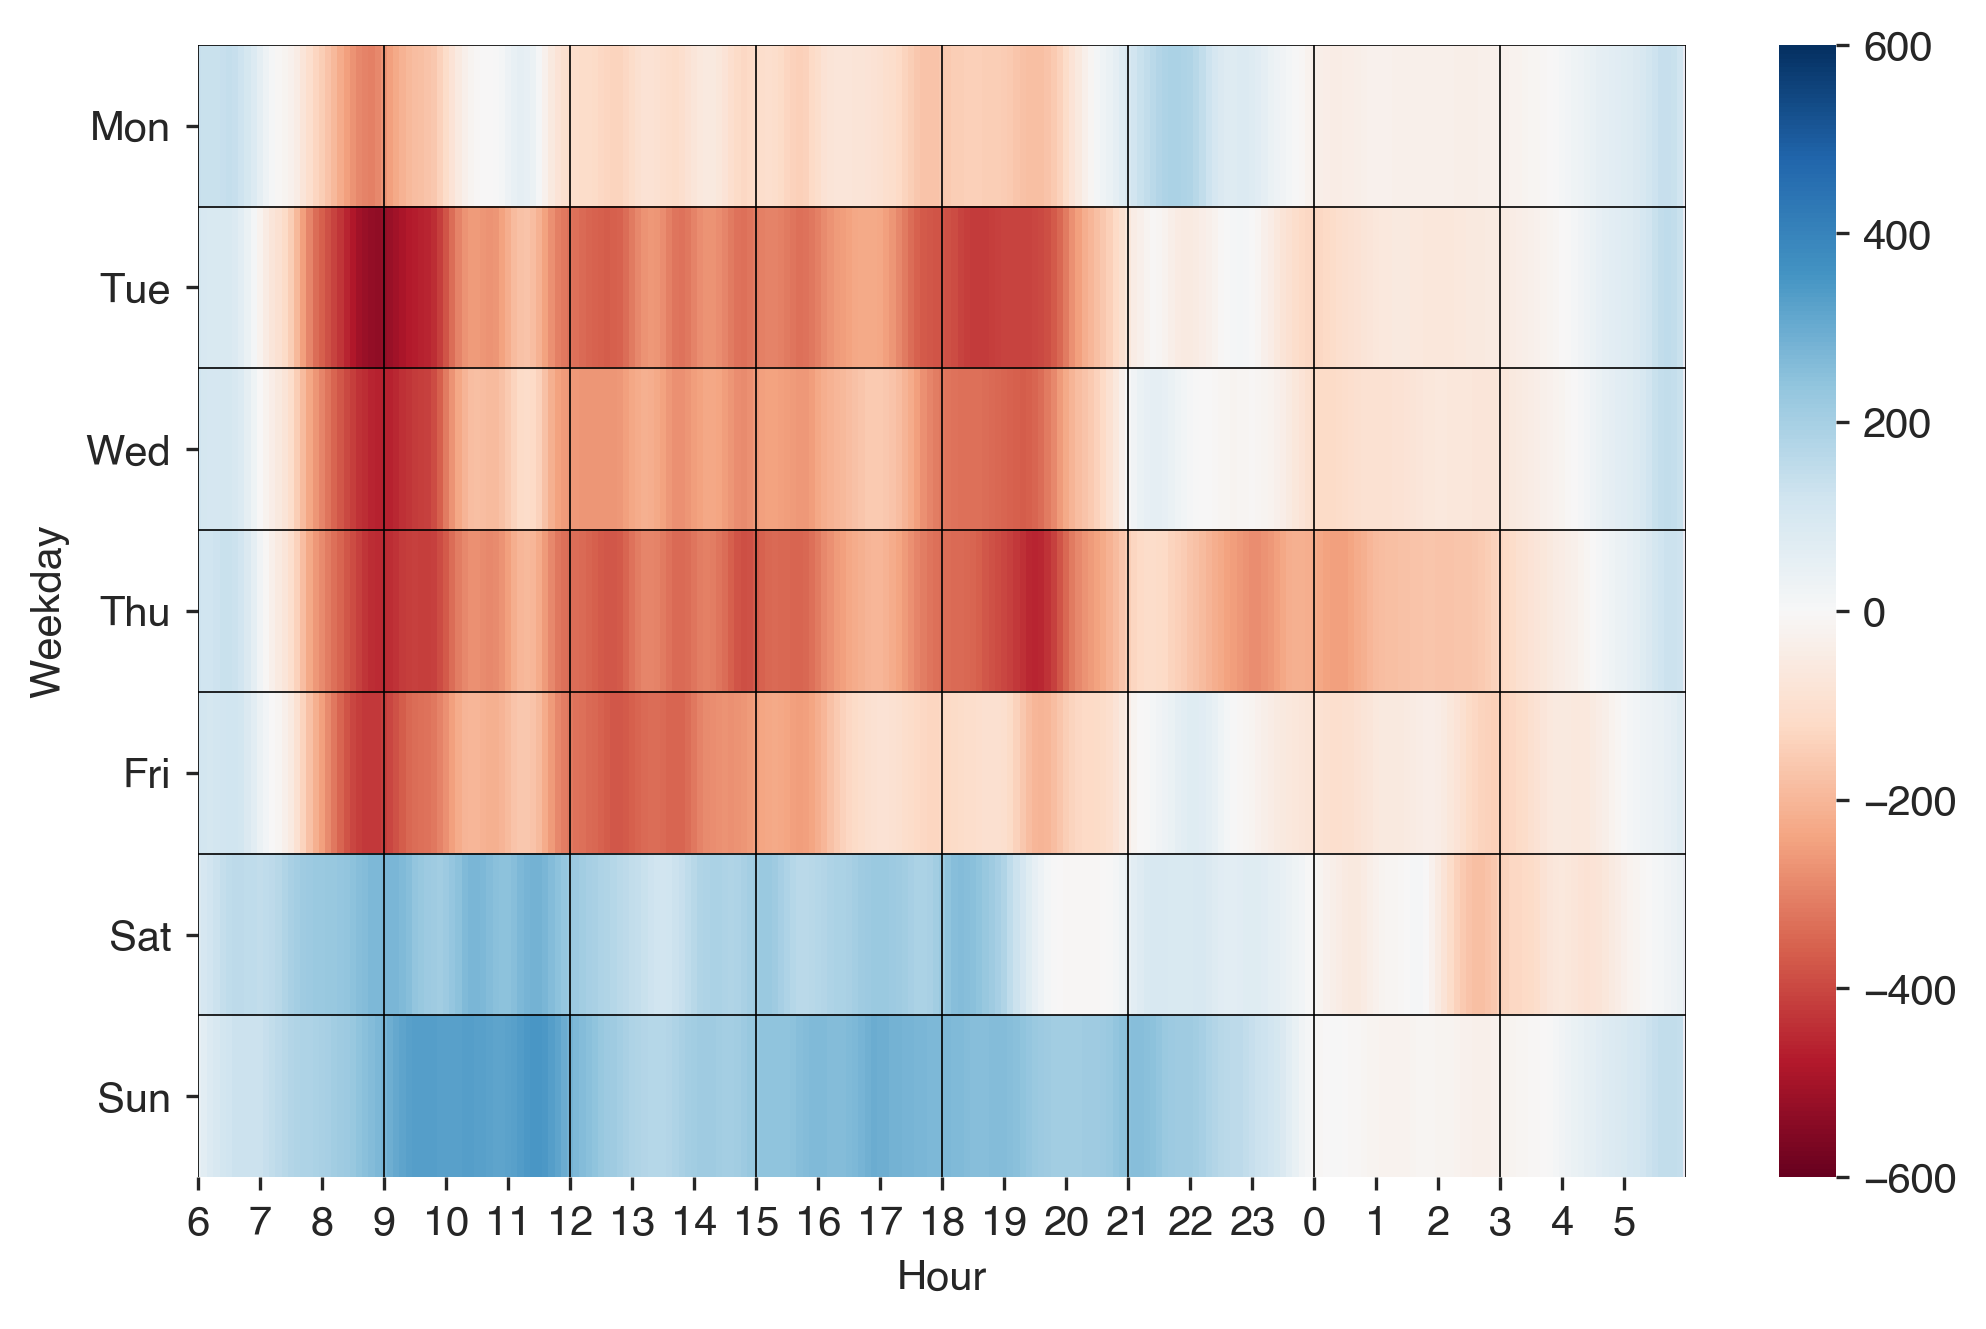

In [48]:
plt.imshow(pickup_trends_smoothed, aspect='auto', interpolation='none', cmap=plt.cm.RdBu, vmin=-600, vmax=600)
plt.gcf().set_size_inches(8, 5)
cb = plt.colorbar(orientation='vertical')

plt.gca().yaxis.set_ticklabels(['', 'Mon', 'Tue',  "Wed", 'Thu', 'Fri',  'Sat', 'Sun'])

plt.xticks(np.roll(np.arange(0, 240, 10), -0))
plt.gca().xaxis.set_ticklabels(np.roll([str(x) for x in range(0, 24)], -6))
plt.xlabel("Hour")
plt.ylabel("Weekday")
plt.grid(False, which='both')

for i in range(7):
    plt.axhline(i-0.5, color='k', lw=0.4)
for i in range(0, 241, 30):
    plt.axvline(i, color='k', lw=0.4)
plt.xlim(0, 240)

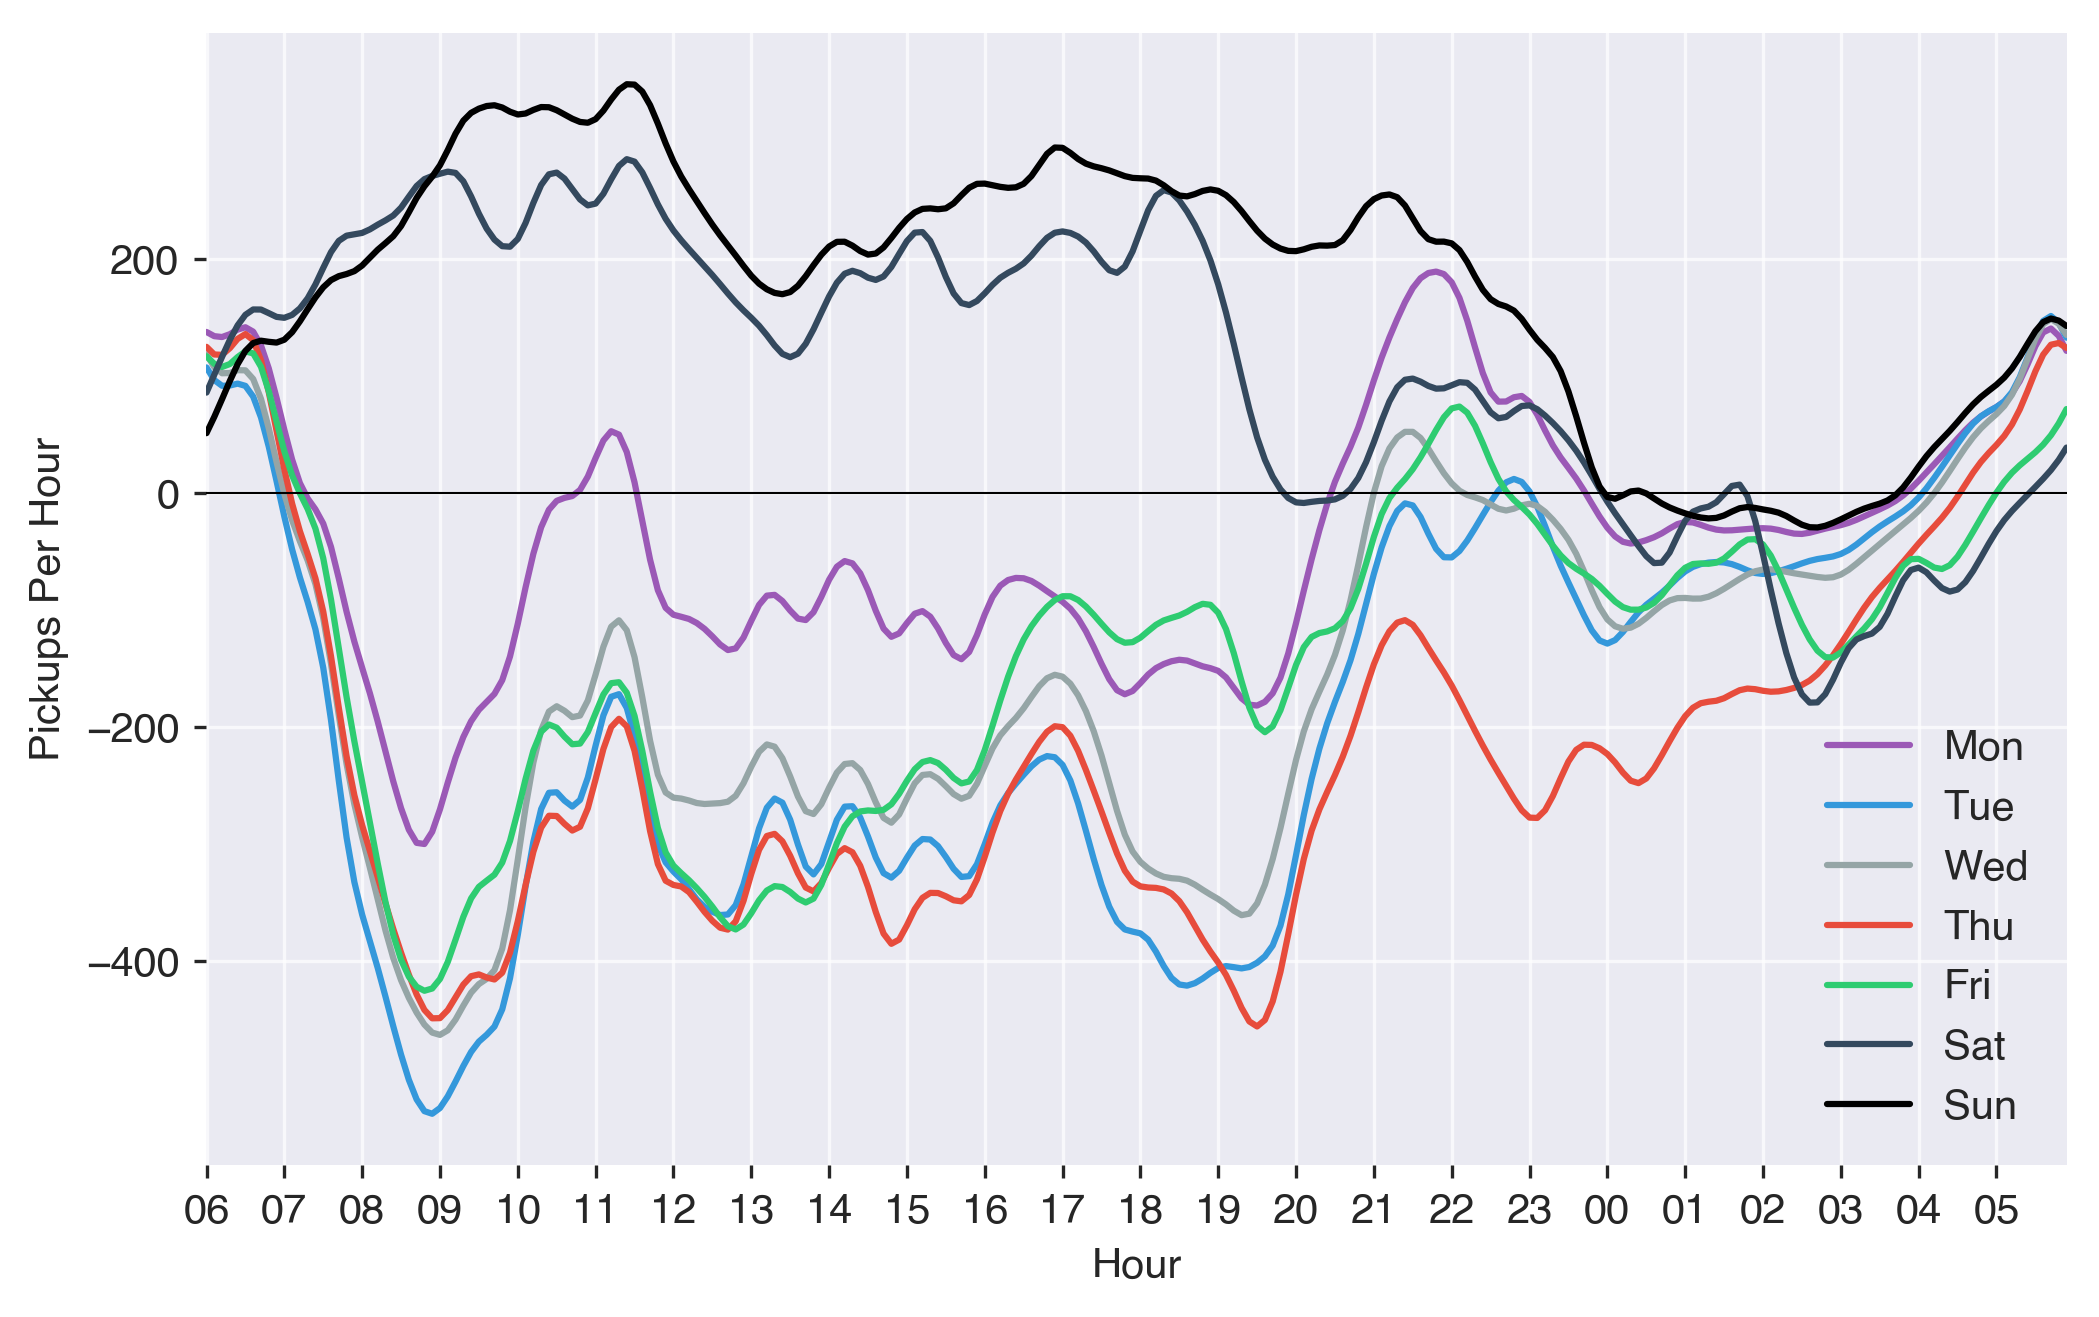

In [49]:
xv = pd.date_range('2009-01-01 06:00:00', '2009-01-02 05:54:00', freq='6T').values

palette = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#2ecc71", "#34495e", "#000000"]

for i,day in enumerate(['Mon', 'Tue',  "Wed", 'Thu', 'Fri',  'Sat', 'Sun']):
    plt.plot(xv, (pickup_trends_smoothed)[i], label=day, color=palette[i])

plt.gcf().set_size_inches(8, 5)
plt.xlim('2009-01-01 06:00:00', '2009-01-02 05:54:00')
plt.legend(loc='lower right')

plt.gca().xaxis.set_ticks(pd.date_range('2009-01-01 06:00:00', '2009-01-02 05:54:00', freq='H').values)
plt.gca().xaxis.set_ticklabels(pd.date_range('2009-01-01 06:00:00', '2009-01-02 05:54:00', freq='H').strftime('%H'))

plt.axhline(0, color='k', lw=0.5)

plt.xlabel("Hour")
plt.ylabel("Pickups Per Hour")

(0, 240)

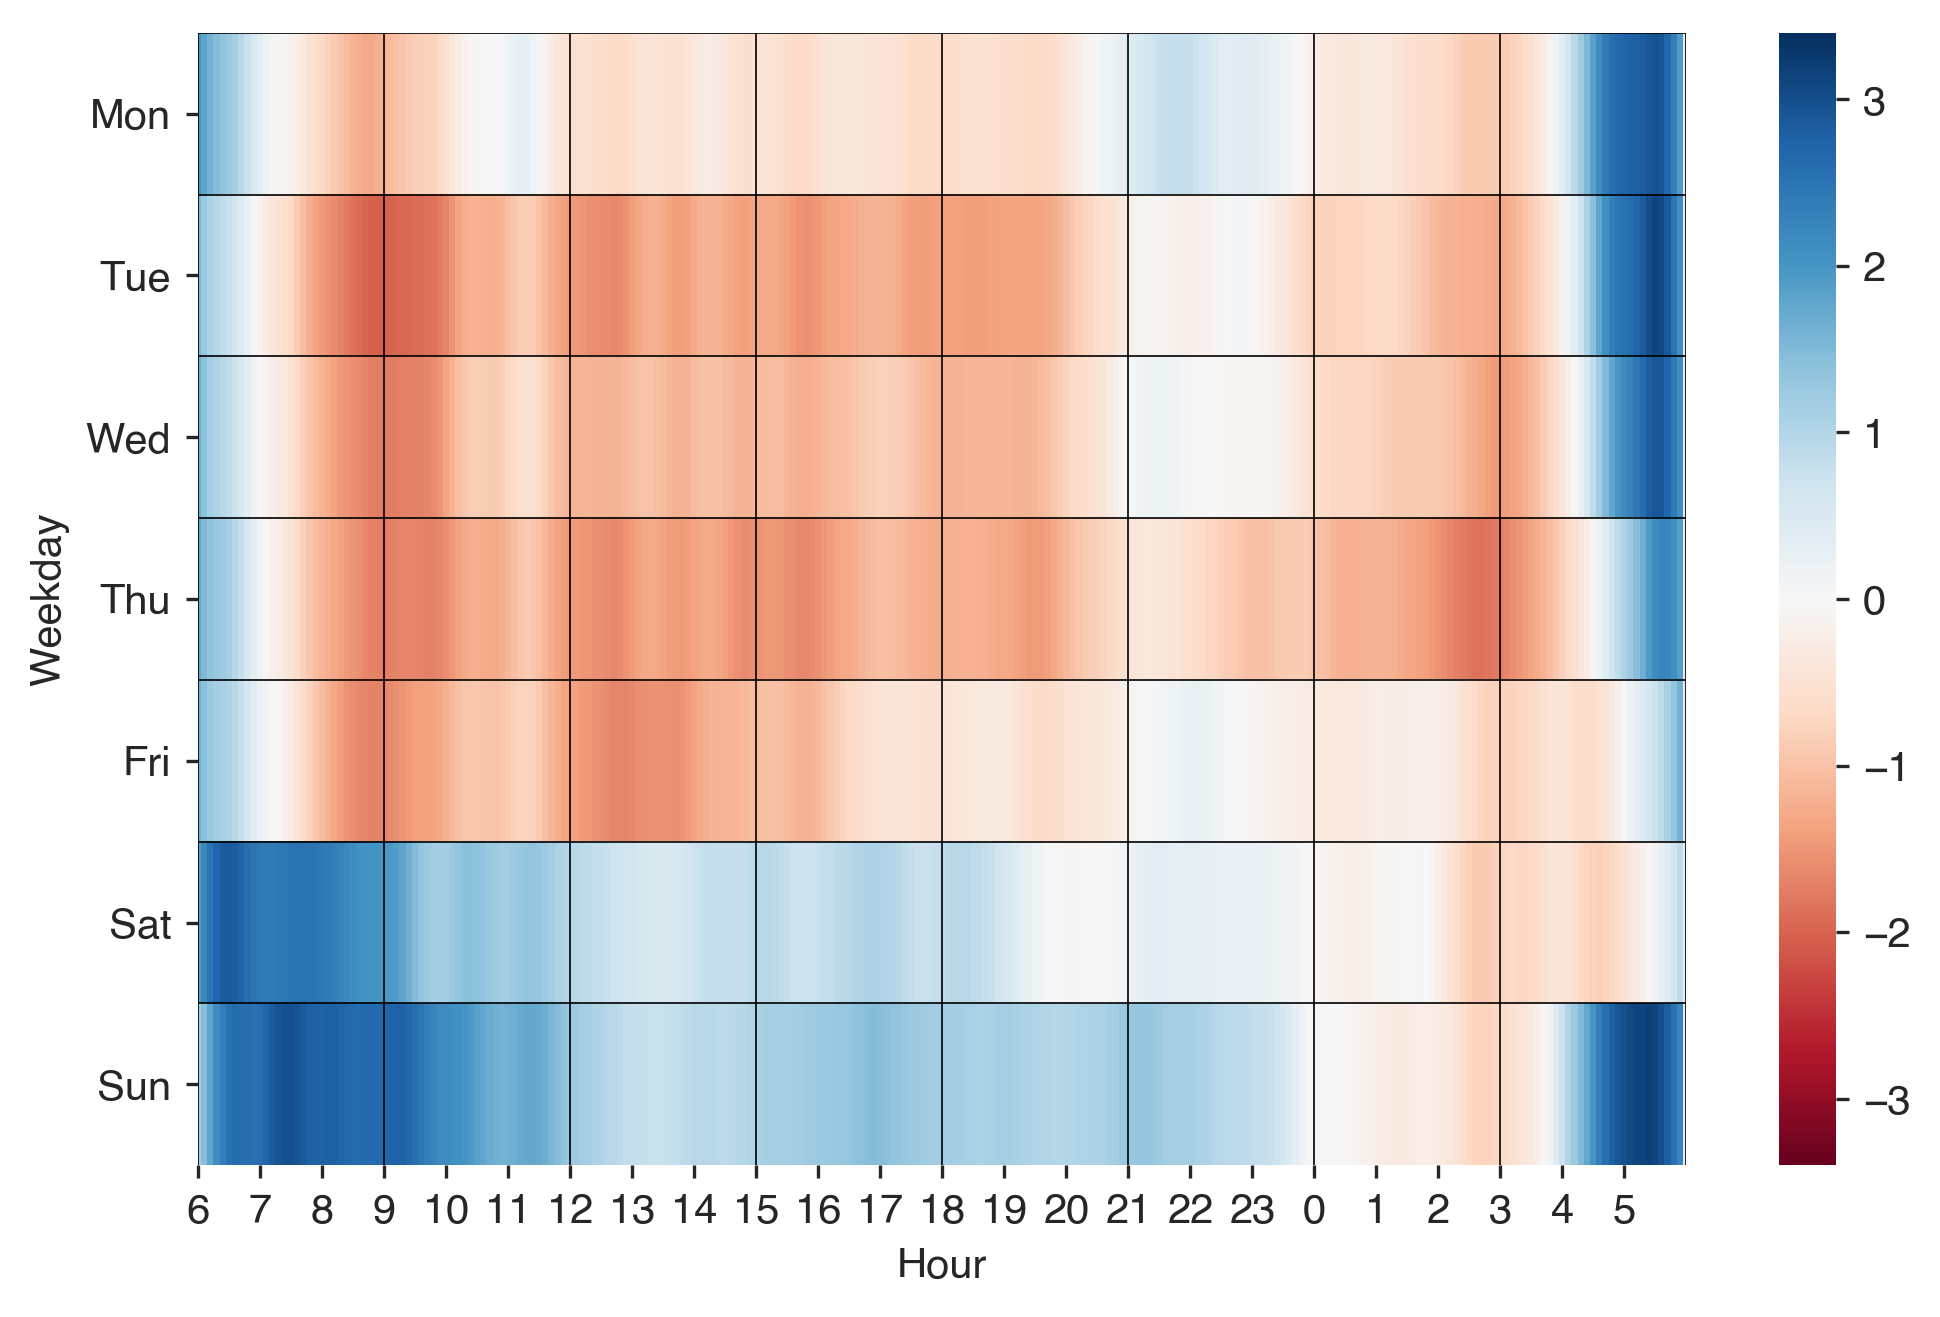

In [50]:
percentage_change = pickup_trends_smoothed/pickup_counts_smoothed*100
# percentage_change[pickup_trends_pvalue > 0.05] = 0.

plt.imshow(percentage_change, aspect='auto', interpolation='none', cmap=plt.cm.RdBu, vmin=-3.4, vmax=3.4)
plt.gcf().set_size_inches(8, 5)
cb = plt.colorbar(orientation='vertical')

plt.gca().yaxis.set_ticklabels(['', 'Mon', 'Tue',  "Wed", 'Thu', 'Fri',  'Sat', 'Sun'])

plt.xticks(np.roll(np.arange(0, 240, 10), -0))
plt.gca().xaxis.set_ticklabels(np.roll([str(x) for x in range(0, 24)], -6))
plt.xlabel("Hour")
plt.ylabel("Weekday")
plt.grid(False, which='both')

for i in range(7):
    plt.axhline(i-0.5, color='k', lw=0.4)
for i in range(0, 241, 30):
    plt.axvline(i, color='k', lw=0.4)
plt.xlim(0, 240)

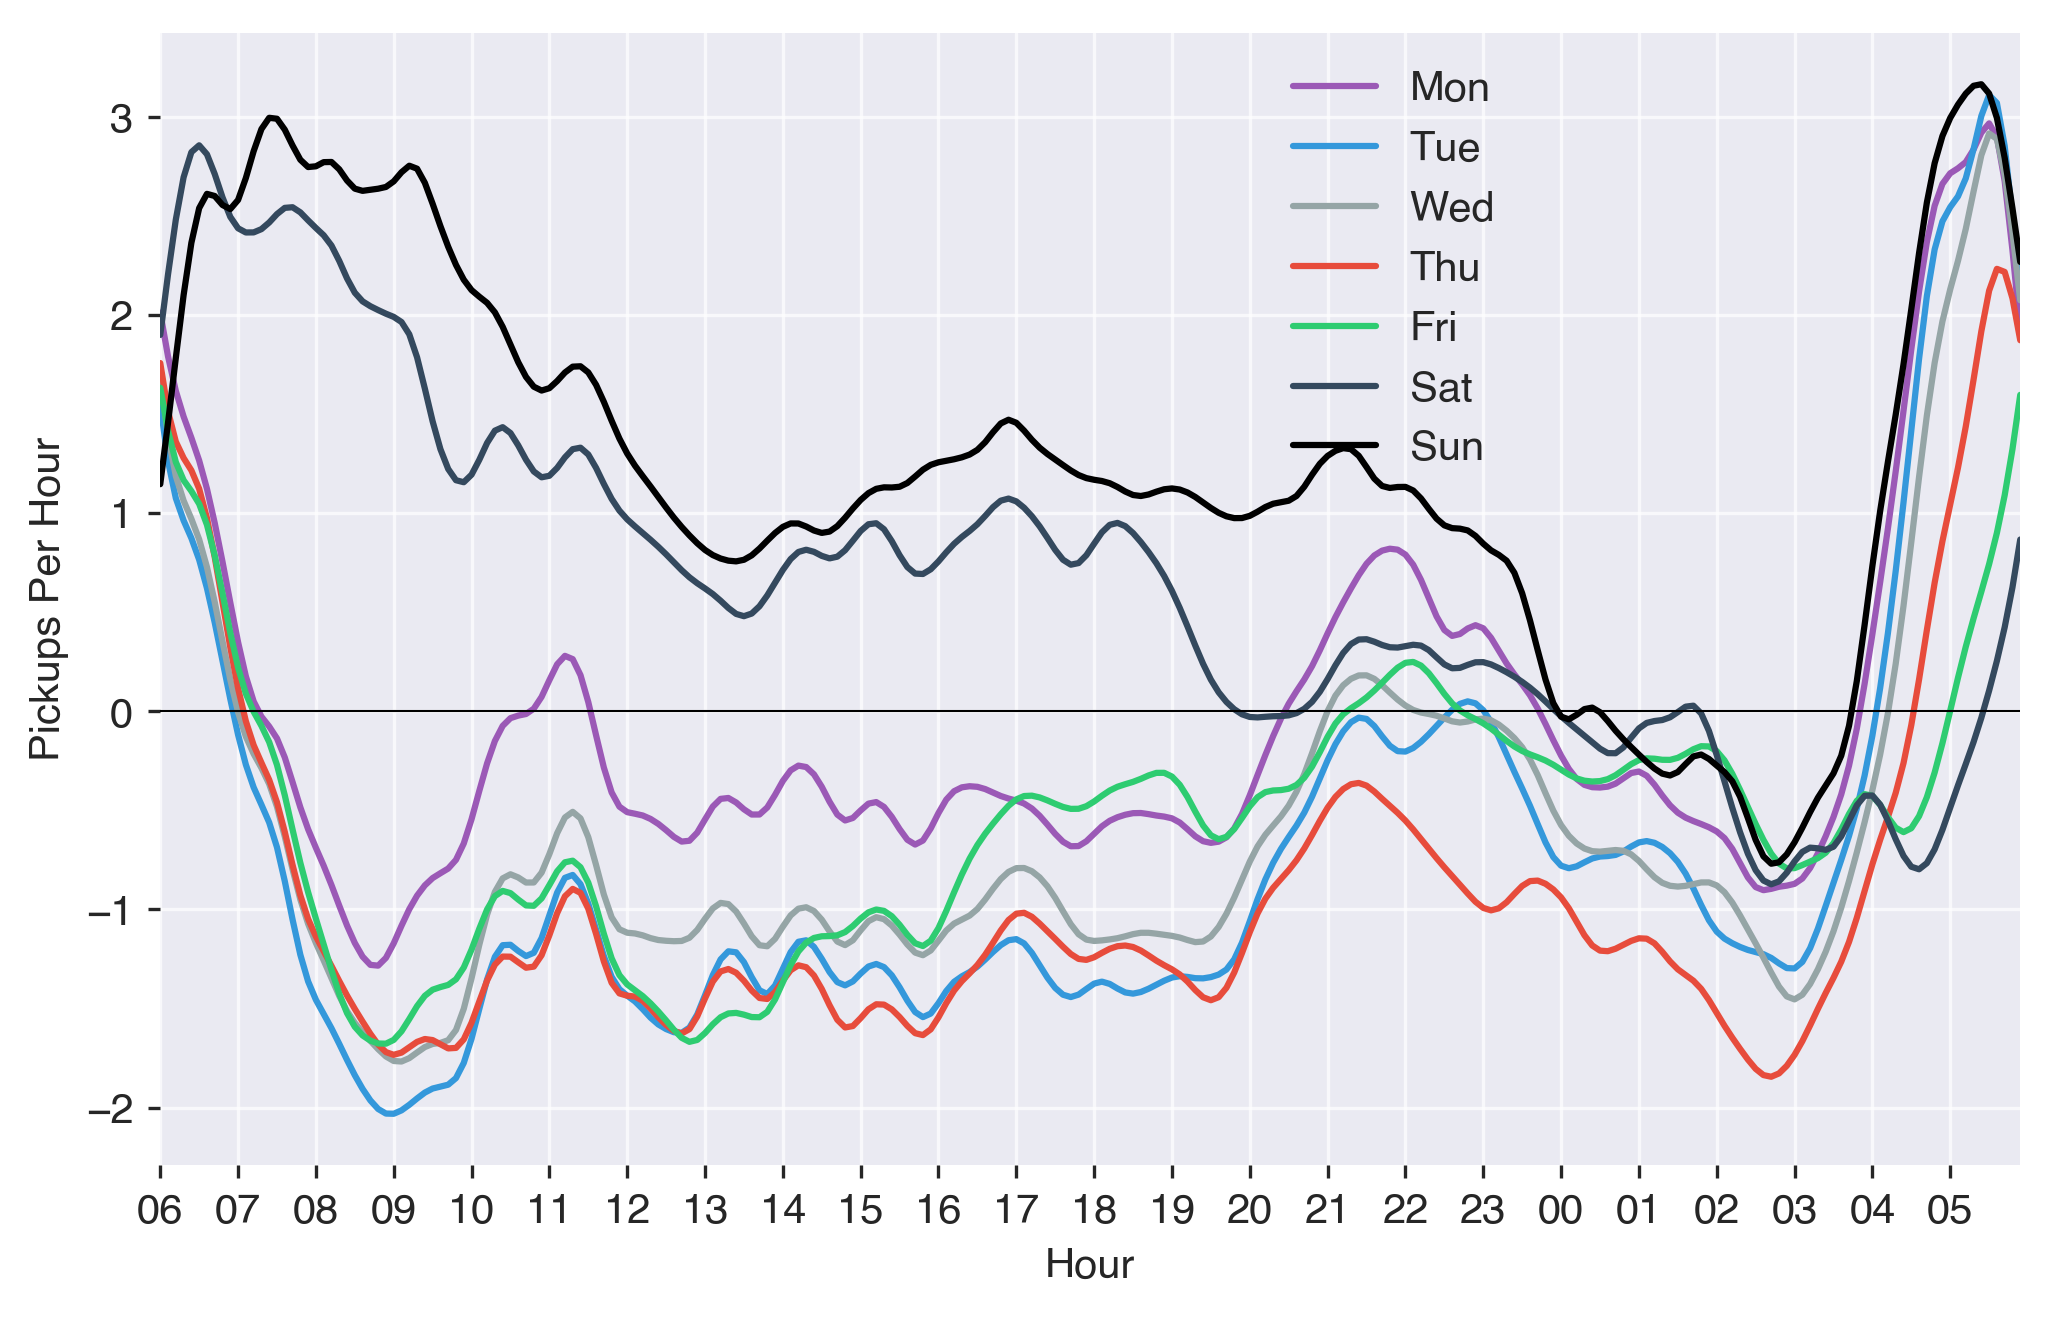

In [51]:
xv = pd.date_range('2009-01-01 06:00:00', '2009-01-02 05:54:00', freq='6T').values

palette = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#2ecc71", "#34495e", "#000000"]

for i,day in enumerate(['Mon', 'Tue',  "Wed", 'Thu', 'Fri',  'Sat', 'Sun']):
    plt.plot(xv, percentage_change[i], label=day, color=palette[i])

plt.gcf().set_size_inches(8, 5)
plt.xlim('2009-01-01 06:00:00', '2009-01-02 05:54:00')
plt.legend(loc=(0.6, 0.6))
# plt.gcf().autofmt_xdate()
plt.gca().xaxis.set_ticks(pd.date_range('2009-01-01 06:00:00', '2009-01-02 05:54:00', freq='H').values)
plt.gca().xaxis.set_ticklabels(pd.date_range('2009-01-01 06:00:00', '2009-01-02 05:54:00', freq='H').strftime('%H'))
# plt.ylim(0, 37000)
plt.axhline(0, color='k', lw=0.5)

plt.xlabel("Hour")
plt.ylabel("Pickups Per Hour")